# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import numpy as np
import json
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3.5"

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [5]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("yarn-client")
conf.set("spark.executor.memory", "6g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

conf.set("spark.executor.instances", "2") # кол-во executor'ов
conf.set("spark.executor.cores", "4") # сколько ядер у каждого

# conf.set("spark.dynamicAllocation.enabled", "true")
# conf.set("spark.shuffle.service.enabled", "true")
# conf.set("spark.dynamicAllocation.initialExecutors", 2)
# conf.set("spark.dynamicAllocation.maxExecutors", 2)

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

In [ ]:
sc.stop()

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [6]:
!hdfs dfs -ls data/ml-25m/

Found 9 items
-rw-r--r--   1 root supergroup      10460 2020-02-02 17:37 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2020-02-02 17:37 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2020-02-02 17:37 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2020-02-02 17:37 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2020-02-02 17:37 data/ml-25m/ml-25m-README.htm
-rw-r--r--   1 root supergroup    3038099 2020-02-02 17:37 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2020-02-02 17:38 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2020-02-02 17:38 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2020-02-02 17:38 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [7]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')
LINKS_PATH = os.path.join(DATA_PATH, 'links.csv')
TMDB_PATH = os.path.join(DATA_PATH, 'tmdb.json')

In [8]:
ratings = sc.textFile(RATINGS_PATH)

In [9]:
ratings.take(5)

['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [10]:
ratings.getNumPartitions()

5

In [11]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [12]:
ratings.count()

25000095

Количество пользователей

In [13]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 14.7 ms, sys: 11.2 ms, total: 25.9 ms
Wall time: 1min 3s


162541

Сохраним датасет в память

In [14]:
ratings = ratings.persist()

In [15]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 21.8 ms, sys: 7.02 ms, total: 28.9 ms
Wall time: 1min 43s


162541

Количество фильмов

In [16]:
ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [125]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [126]:
genres =  movies \
    .map(lambda s: s.split(',')[::2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .filter(lambda arr: '(' not in arr[1] and ')' not in arr[1])\
    .keyBy(lambda arr: int(arr[0]))

genres.take(5)

[(1, ['1', 'Adventure|Animation|Children|Comedy|Fantasy']),
 (2, ['2', 'Adventure|Children|Fantasy']),
 (3, ['3', 'Comedy|Romance']),
 (4, ['4', 'Comedy|Drama|Romance']),
 (5, ['5', 'Comedy'])]

In [127]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(196959, (5.0, ['196959', 'I Am JFK Jr. (2016)'])),
 (180663, (5.0, ['180663', '"Goodbye'])),
 (147966, (5.0, ['147966', "Tarzan's Fight for Life (1958)"])),
 (131628, (5.0, ['131628', 'Loaded (2014)'])),
 (131922, (5.0, ['131922', 'Private Duty Nurses (1971)'])),
 (188573, (5.0, ['188573', 'Judy (2014)'])),
 (164787, (5.0, ['164787', 'You Cast A Spell On Me (2015)'])),
 (132321, (5.0, ['132321', 'Black Oak Conspiracy (1977)'])),
 (165221, (5.0, ['165221', 'Elf Bowling the Movie (2007)'])),
 (149268, (5.0, ['149268', 'The Pied Piper (1942)']))]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [28]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [29]:
! hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2020-02-02 18:05 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup      58903 2020-02-02 18:05 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     112361 2020-02-02 18:05 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     131524 2020-02-02 18:05 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     114377 2020-02-02 18:05 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     133576 2020-02-02 18:05 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     117783 2020-02-02 18:05 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     143242 2020-02-02 18:05 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     131984 2020-02-02 18:05 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     167729 2020-02-02 18:05 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [30]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [31]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [32]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

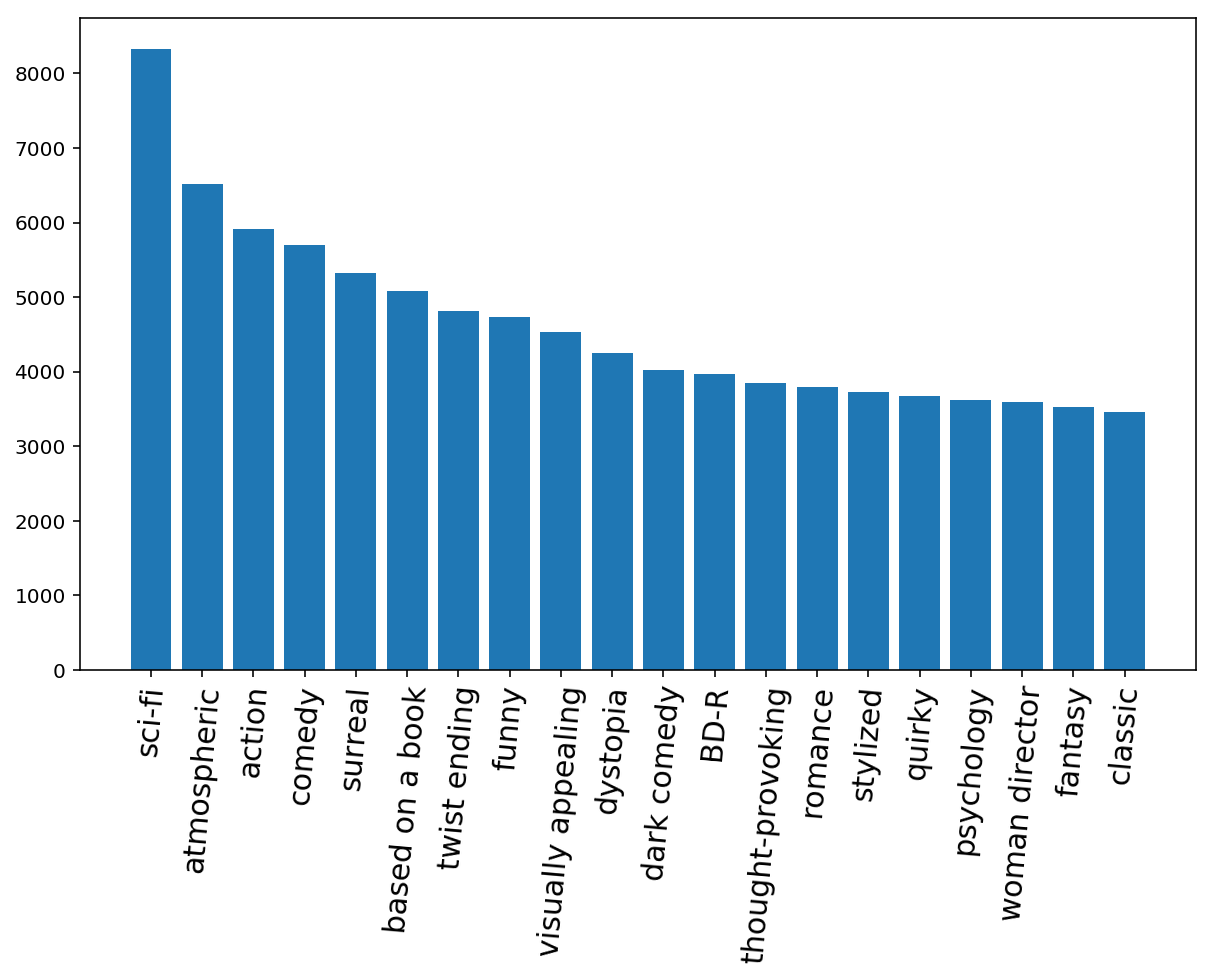

In [33]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [34]:
ratings \
    .map(lambda r: (r.movie_id, 1))\
    .reduceByKey(lambda a, b: a + b)\
    .join(movies)\
    .sortBy(lambda t: t[1], ascending=False)\
    .take(10)

[(356, (81491, ['356', 'Forrest Gump (1994)'])),
 (318, (81482, ['318', '"Shawshank Redemption'])),
 (296, (79672, ['296', 'Pulp Fiction (1994)'])),
 (593, (74127, ['593', '"Silence of the Lambs'])),
 (2571, (72674, ['2571', '"Matrix'])),
 (260, (68717, ['260', 'Star Wars: Episode IV - A New Hope (1977)'])),
 (480, (64144, ['480', 'Jurassic Park (1993)'])),
 (527, (60411, ['527', "Schindler's List (1993)"])),
 (110, (59184, ['110', 'Braveheart (1995)'])),
 (2959, (58773, ['2959', 'Fight Club (1999)']))]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [35]:
ratings \
    .filter(lambda r: r.rating == 5.0)\
    .map(lambda r: (r.movie_id, 1))\
    .reduceByKey(lambda a, b: a + b)\
    .join(movies)\
    .sortBy(lambda t: t[1], ascending=False)\
    .take(10)

[(318, (39553, ['318', '"Shawshank Redemption'])),
 (296, (32169, ['296', 'Pulp Fiction (1994)'])),
 (356, (25918, ['356', 'Forrest Gump (1994)'])),
 (260, (25804, ['260', 'Star Wars: Episode IV - A New Hope (1977)'])),
 (2571, (25482, ['2571', '"Matrix'])),
 (527, (24853, ['527', "Schindler's List (1993)"])),
 (593, (24801, ['593', '"Silence of the Lambs'])),
 (858, (24418, ['858', '"Godfather'])),
 (50, (21585, ['50', '"Usual Suspects'])),
 (2959, (21486, ['2959', 'Fight Club (1999)']))]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

In [36]:
avg_rating_buckets = movie_avg_rating\
    .map(lambda key_value: (int(key_value[1] * 10), 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

In [37]:
avg_rating_buckets = list(map(lambda kv: (kv[0], kv[1]), avg_rating_buckets))

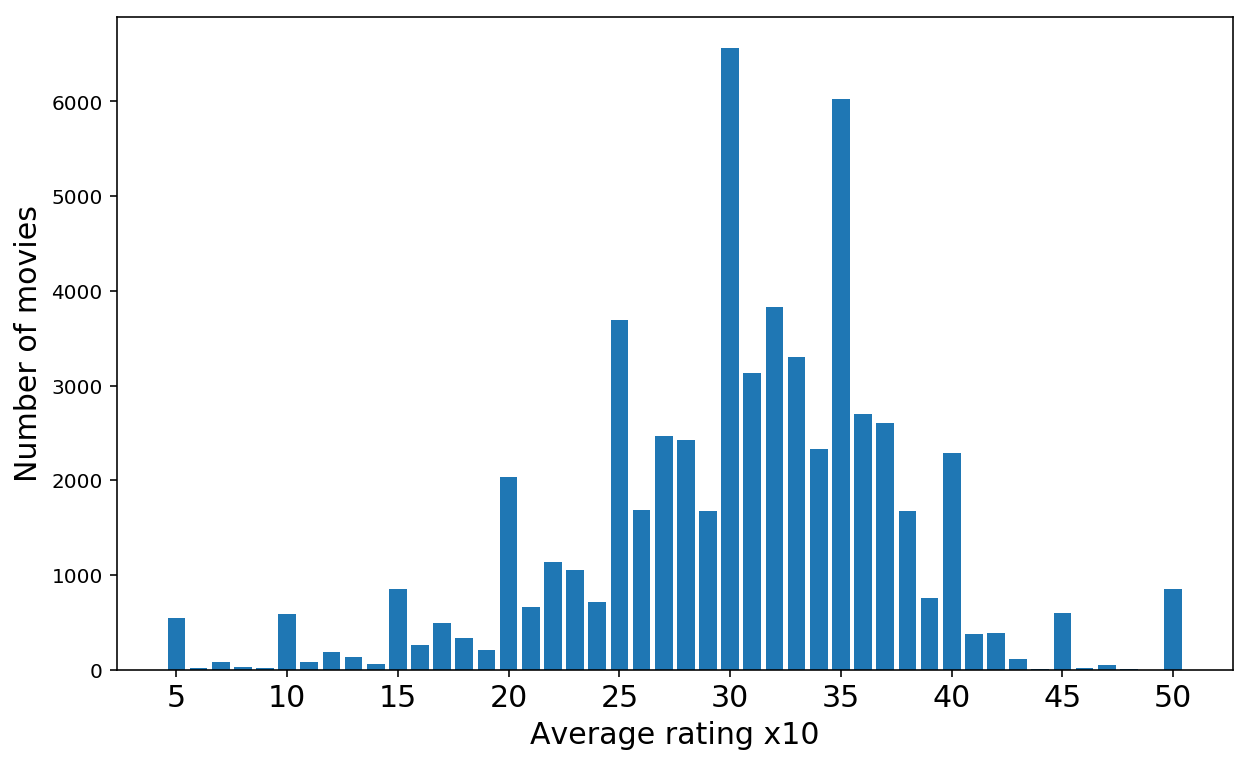

In [38]:
keys, values = zip(*avg_rating_buckets)

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(sorted(keys)[::5] + [50], fontsize=15)
plt.bar(keys, values, align="center")
plt.xlabel("Average rating x10", fontsize=15)
plt.ylabel("Number of movies", fontsize=15)
plt.show()

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

In [39]:
number_of_ratings_buckets = ratings \
    .map(lambda r: (r.movie_id, 1))\
    .reduceByKey(lambda a, b: a + b)\
    .map(lambda key_value: (int(np.ceil(np.log10(key_value[1]))), 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

In [40]:
sorted(number_of_ratings_buckets)

[(0, 10298), (1, 25392), (2, 13066), (3, 6501), (4, 3202), (5, 588)]

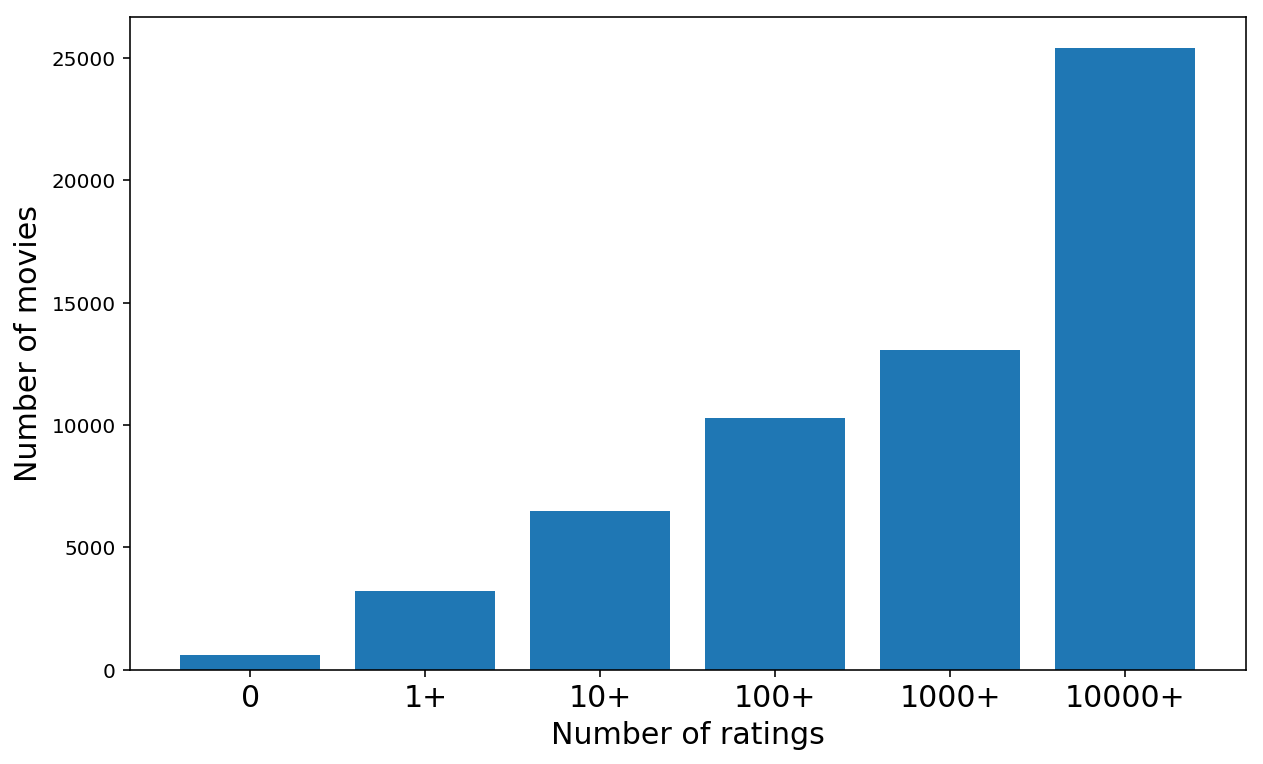

In [41]:
keys, values = zip(*number_of_ratings_buckets)

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(fontsize=15)
plt.bar(["0", "1+", "10+", "100+", "1000+", "10000+"], sorted(values), align="center")
plt.xlabel("Number of ratings", fontsize=15)
plt.ylabel("Number of movies", fontsize=15)
plt.show()

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

In [128]:
movies.take(5), genres.take(5)

([(1, ['1', 'Toy Story (1995)']),
  (2, ['2', 'Jumanji (1995)']),
  (3, ['3', 'Grumpier Old Men (1995)']),
  (4, ['4', 'Waiting to Exhale (1995)']),
  (5, ['5', 'Father of the Bride Part II (1995)'])],
 [(1, ['1', 'Adventure|Animation|Children|Comedy|Fantasy']),
  (2, ['2', 'Adventure|Children|Fantasy']),
  (3, ['3', 'Comedy|Romance']),
  (4, ['4', 'Comedy|Drama|Romance']),
  (5, ['5', 'Comedy'])])

In [129]:
genre_counts = genres \
    .flatMap(lambda key_value: key_value[1][1].split('|'))\
    .map(lambda g: (g, 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

In [130]:
genre_counts = sorted(genre_counts, key=lambda gc: -gc[1])

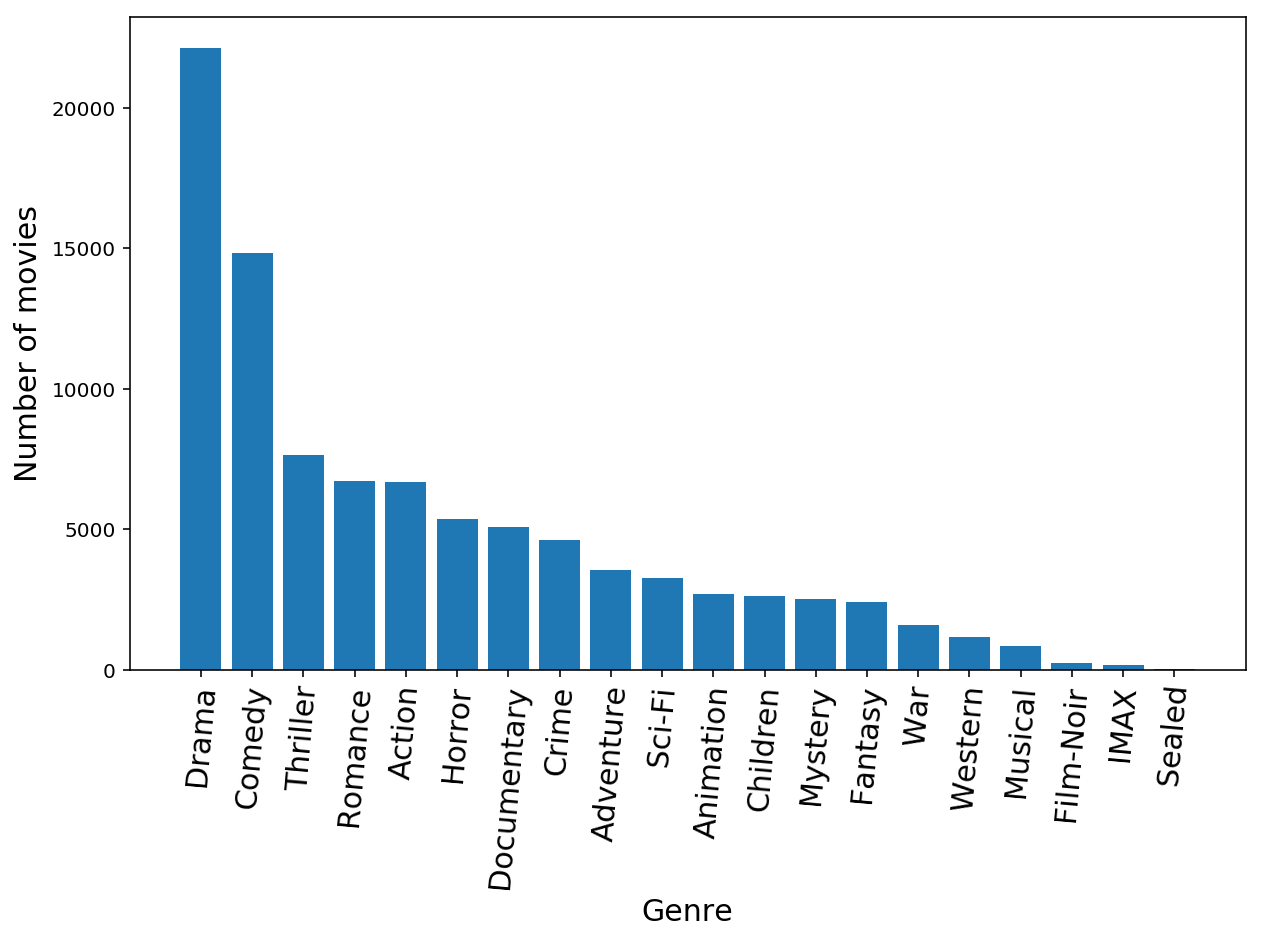

In [131]:
keys, values = zip(*genre_counts[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.xlabel("Genre", fontsize=15)
plt.ylabel("Number of movies", fontsize=15)
plt.show()

In [132]:
top_genres = keys
top_genres

('Drama',
 'Comedy',
 'Thriller',
 'Romance',
 'Action',
 'Horror',
 'Documentary',
 'Crime',
 'Adventure',
 'Sci-Fi',
 'Animation',
 'Children',
 'Mystery',
 'Fantasy',
 'War',
 'Western',
 'Musical',
 'Film-Noir',
 'IMAX',
 ' Sealed')

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [46]:
links = sc.textFile(LINKS_PATH)
links.take(5)

['movieId,imdbId,tmdbId',
 '1,0114709,862',
 '2,0113497,8844',
 '3,0113228,15602',
 '4,0114885,31357']

In [47]:
links = links \
    .map(lambda s: s.split(',')[::2])\
    .filter(lambda arr: arr[0].isdigit())\
    .keyBy(lambda arr: int(arr[0]))

links.take(5)

[(1, ['1', '862']),
 (2, ['2', '8844']),
 (3, ['3', '15602']),
 (4, ['4', '31357']),
 (5, ['5', '11862'])]

In [48]:
tmdb = sc.textFile(TMDB_PATH)

In [49]:
tmdb = tmdb \
    .map(lambda s: json.loads(s))\
    .filter(lambda movie_info: 'title' in movie_info)\
    .keyBy(lambda movie_info: int(movie_info['id']))

In [50]:
id2title = tmdb \
    .mapValues(lambda movie_info: movie_info['title'])

In [51]:
actor_records = tmdb \
    .flatMapValues(lambda movie_info: movie_info['casts']['cast'])\
    .keyBy(lambda title_actor: int(title_actor[1]['id']))

In [52]:
actor_records.take(3)

[(31,
  (862,
   {'cast_id': 14,
    'character': 'Woody (voice)',
    'credit_id': '52fe4284c3a36847f8024f95',
    'gender': 2,
    'id': 31,
    'name': 'Tom Hanks',
    'order': 0,
    'profile_path': '/xxPMucou2wRDxLrud8i2D4dsywh.jpg'})),
 (12898,
  (862,
   {'cast_id': 15,
    'character': 'Buzz Lightyear (voice)',
    'credit_id': '52fe4284c3a36847f8024f99',
    'gender': 2,
    'id': 12898,
    'name': 'Tim Allen',
    'order': 1,
    'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'})),
 (7167,
  (862,
   {'cast_id': 16,
    'character': 'Mr. Potato Head (voice)',
    'credit_id': '52fe4284c3a36847f8024f9d',
    'gender': 2,
    'id': 7167,
    'name': 'Don Rickles',
    'order': 2,
    'profile_path': '/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg'}))]

In [53]:
# Films starring Tom Hanks (including voice-acting)

hanks_movies = actor_records \
    .filter(lambda key_value: key_value[0] == 31)\
    .map(lambda key_value: key_value[1][0])\
    .keyBy(lambda movie_id: movie_id)\
    .join(id2title)\
    .collect()

for _, (_, title) in hanks_movies:
    print(title)

The Terminal
Sleepless in Seattle
Big
California Typewriter
Cast Away
Mazes and Monsters
Beyond Boundaries: The Harvey Weinstein Scandal
He Knows You're Alone
The Celluloid Closet
Forrest Gump
Toy Story of Terror!
Shooting War
Road to Perdition
The Extraordinary Voyage
Defying the Nazis: The Sharps' War
A League of Their Own
Hawaiian Vacation
And the Oscar Goes To...
The Great Buck Howard
Small Fry
Cars
Inferno
Ithaca
The Post
The Ladykillers
Punchline
Philadelphia
The Money Pit
Captain Phillips
Angels & Demons
The Pixar Story
The Da Vinci Code
Joe Versus the Volcano
Splash
Radio Flyer
Elvis Has Left the Building
Turner & Hooch
Return with Honor
Bachelor Party
You've Got Mail
That Thing You Do!
Saving Mr. Banks
Dragnet
The Man with One Red Shoe
Everything Is Copy
Quincy
Apollo 13
Catch Me If You Can
Toy Story
Bridge of Spies
Cloud Atlas
Every Time We Say Goodbye
Sully
Charlie Wilson's War
Toy Story 4
A Hologram for the King
Spielberg
The Bonfire of the Vanities
The 'Burbs
The Circle
Ma

In [54]:
id2actor = actor_records \
    .mapValues(lambda title_actor: title_actor[1]['name'])\
    .distinct()

In [55]:
id2actor.take(10)

[(34758, 'Joseph Cawthorn'),
 (1799267, 'Diana C. Skinner'),
 (1410329, 'Nikki Chapman'),
 (104211, 'Jean-Loup Philippe'),
 (1372535, 'Ryouko Ima'),
 (2083671, 'Manny La Carruba'),
 (1158351, 'Paige Lauren Billiot'),
 (1833014, 'Harry Johnson'),
 (2121149, 'Jonathan Mårtensson'),
 (55253, 'Michelle Krusiec')]

In [56]:
actor_records \
    .mapValues(lambda title_actor: 1)\
    .reduceByKey(lambda a, b: a + b)\
    .join(id2actor)\
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(121323, (380, 'Bess Flowers')),
 (15831, (184, 'Frank Welker')),
 (113, (175, 'Christopher Lee')),
 (78077, (158, 'Clarence Nash')),
 (30530, (152, 'Irving Bacon')),
 (8516, (146, 'John Carradine')),
 (4165, (142, 'John Wayne')),
 (33923, (140, 'Mel Blanc')),
 (2231, (134, 'Samuel L. Jackson')),
 (21315, (130, 'Eric Roberts'))]

### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [133]:
id2release_year = tmdb \
    .mapValues(lambda movie_info: movie_info["release_date"])\
    .filter(lambda key_value: key_value[1] != "")\
    .mapValues(lambda release_date: int(release_date.split("-")[0]))

In [200]:
genre_tmdb = genres \
    .join(links)\
    .filter(lambda key_value: key_value[1][1][1] != "")\
    .map(lambda key_value: (int(key_value[1][1][1]), key_value[1][0][1]))\
    .flatMapValues(lambda s: s.split('|'))

In [201]:
genre_release = genre_tmdb \
    .filter(lambda key_value: key_value[1] in top_genres)\
    .join(id2release_year)\

In [202]:
genre_release.take(10)

[(16387, ('Adventure', 1966)),
 (16387, ('Sci-Fi', 1966)),
 (98308, ('Comedy', 1988)),
 (98308, ('Horror', 1988)),
 (52920, ('Comedy', 1978)),
 (52920, ('Crime', 1978)),
 (14, ('Drama', 1999)),
 (14, ('Romance', 1999)),
 (49168, ('Drama', 1988)),
 (49168, ('Romance', 1988))]

In [203]:
year_counts = genre_release \
    .map(lambda key_value: (key_value[1][1], 1))\
    .reduceByKey(lambda a, b: a + b)

In [204]:
year_counts_list = year_counts.collect()

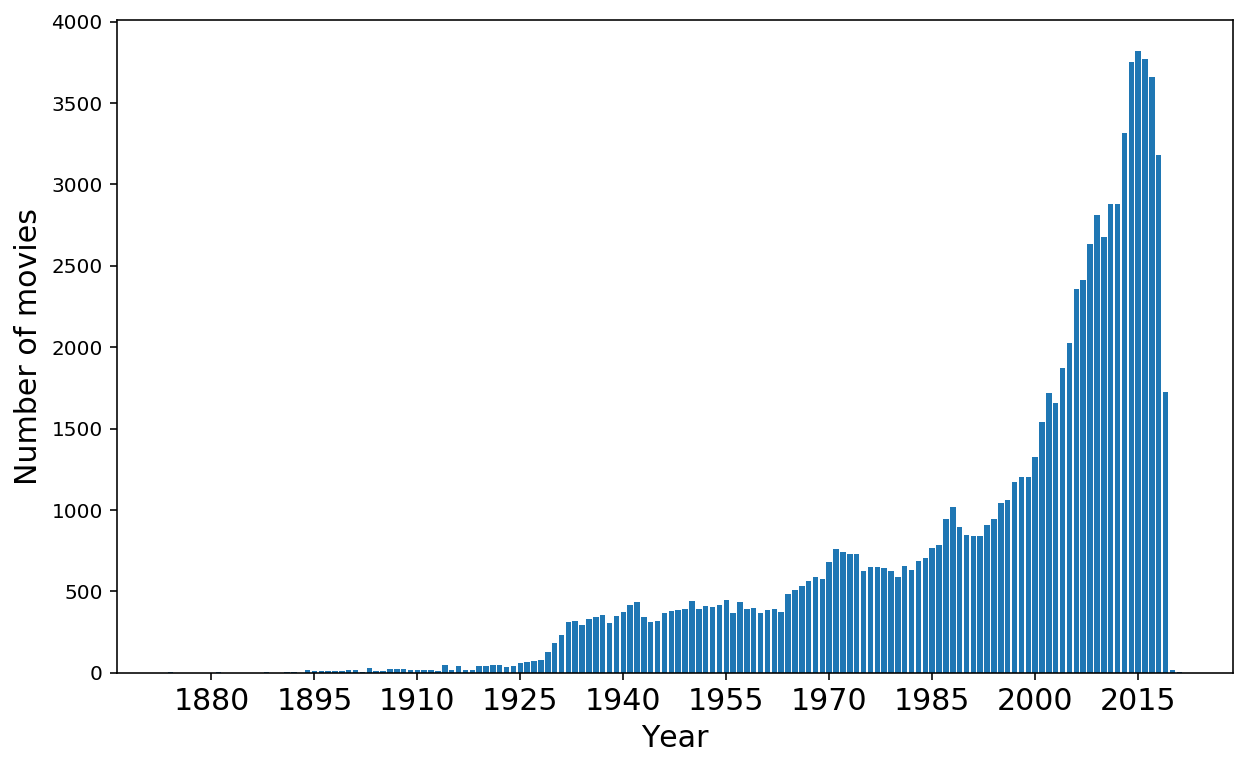

In [205]:
keys, values = zip(*year_counts_list)

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(np.arange(1880, 2021, 15), fontsize=15)
plt.bar(keys, values, align="center")
plt.xlabel("Year", fontsize=15)
plt.ylabel("Number of movies", fontsize=15)
plt.show()

In [206]:
genre_year = genre_release \
    .map(lambda key_value: (key_value[1], 1))\
    .filter(lambda key_value: 1930 <= key_value[0][1] <= 2019)\
    .reduceByKey(lambda a, b: a + b)\
    .map(lambda key_value: (key_value[0][1], (key_value[0][0], key_value[1])))\
    .join(year_counts)\
    .mapValues(lambda info_tuple: (info_tuple[0][0], info_tuple[0][1] / info_tuple[1]))\
    .collect()

In [207]:
years, infos = zip(*genre_year)

In [208]:
unique_years = sorted(np.unique(years))
y = np.zeros((len(top_genres), len(unique_years)), dtype=np.float32)

genre2id = {genre: i for i, genre in enumerate(top_genres)}
year2id = {year: i for i, year in enumerate(unique_years)}

for year, (genre, ratio) in zip(years, infos):
    y[genre2id[genre]][year2id[year]] += ratio

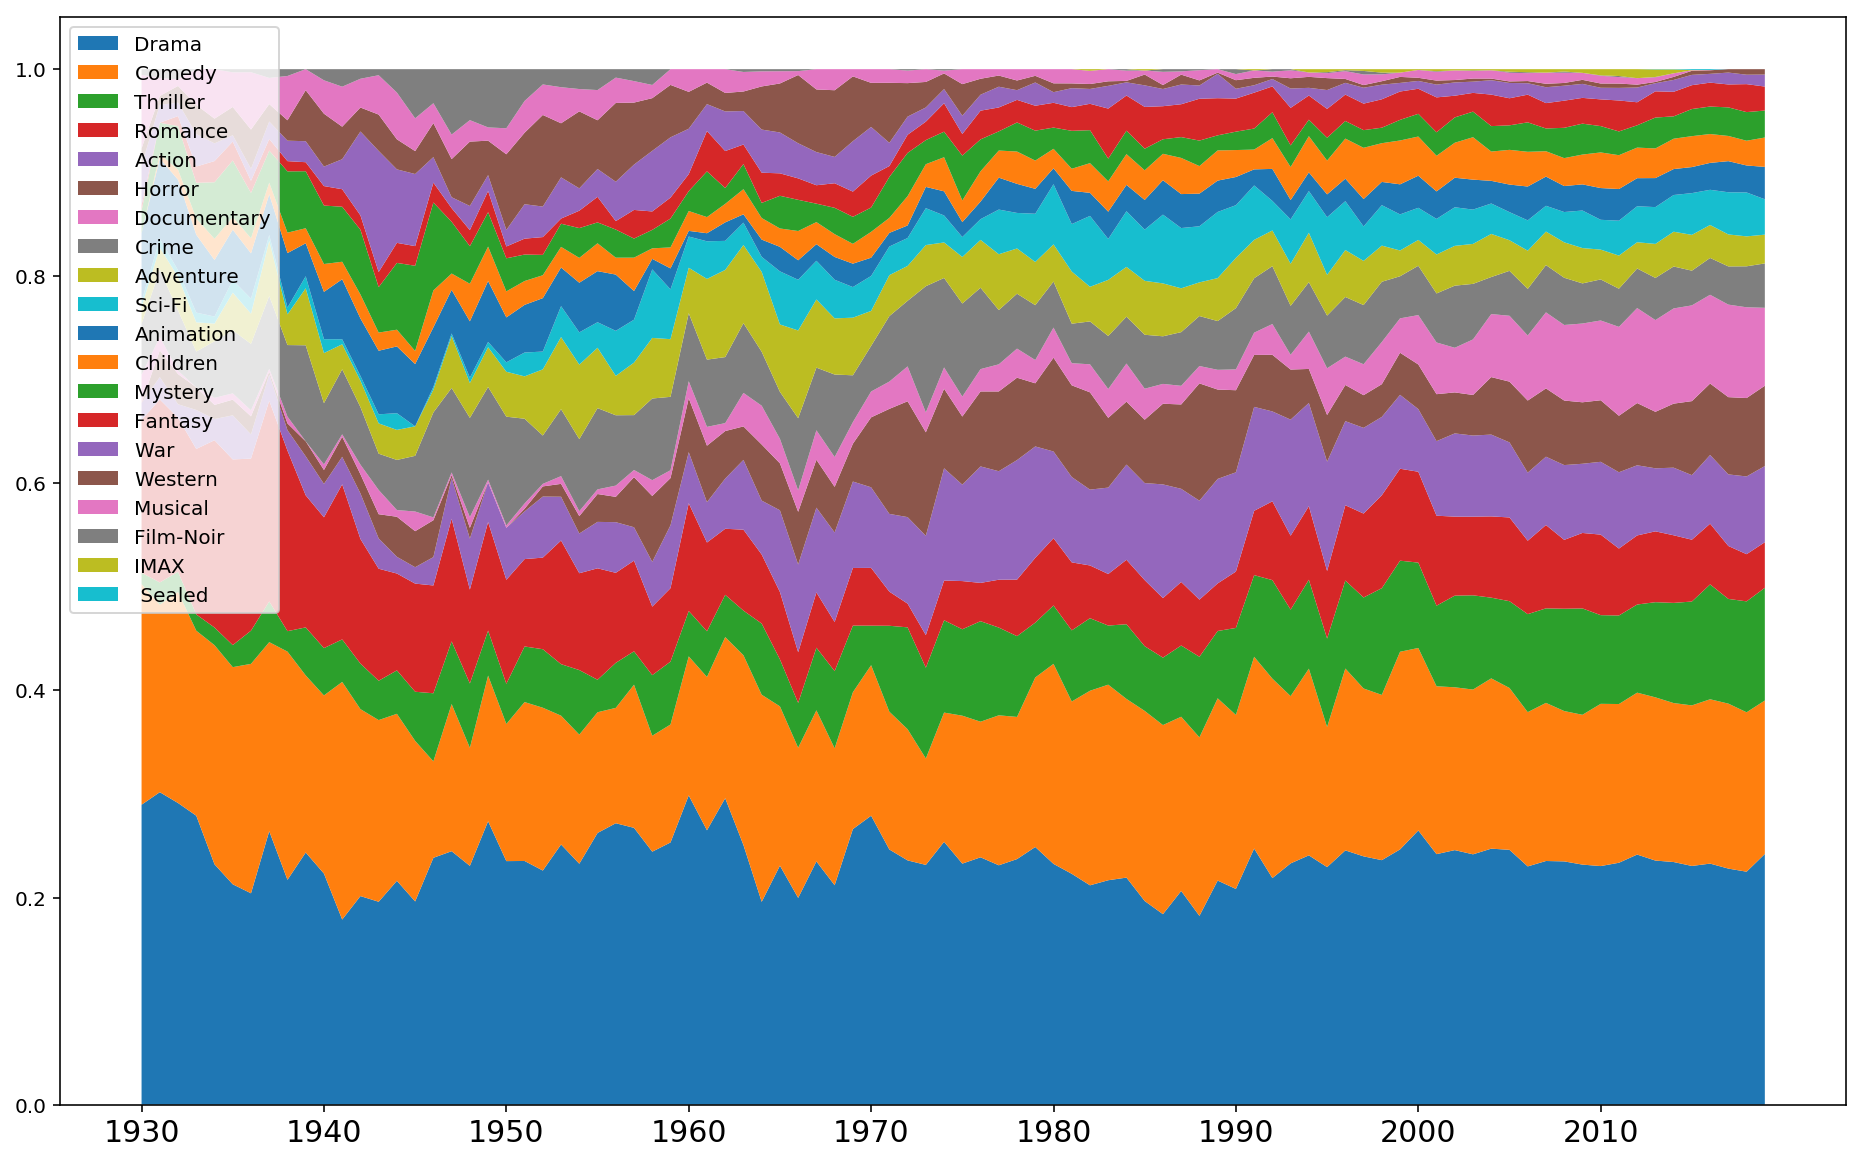

In [209]:
f, ax = plt.subplots(figsize=(16, 10))

ax.stackplot(unique_years, y, labels=top_genres)
ax.legend(loc='upper left')
plt.xticks(unique_years[::10], fontsize=15)
plt.show()

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [198]:
id2money = tmdb \
    .mapValues(lambda movie_info: (movie_info["revenue"], movie_info["budget"]))\
    .filter(lambda key_value: key_value[1][0] > 0 and key_value[1][1] > 0)\

In [199]:
id2money.take(10)

[(862, (373554033, 30000000)),
 (8844, (262797249, 65000000)),
 (31357, (81452156, 16000000)),
 (949, (187436818, 60000000)),
 (11860, (53672080, 58000000)),
 (9091, (64350171, 35000000)),
 (710, (352194034, 58000000)),
 (9087, (107879496, 62000000)),
 (10858, (13681765, 44000000)),
 (1408, (10017322, 98000000))]

In [212]:
genre_money = genre_tmdb \
    .filter(lambda key_value: key_value[1] in top_genres)\
    .join(id2money)\
    .map(lambda key_value: key_value[1])

In [213]:
genre_money.take(10)

[('Drama', (356296601, 15000000)),
 ('Romance', (356296601, 15000000)),
 ('Action', (150000000, 31500000)),
 ('Drama', (150000000, 31500000)),
 ('War', (150000000, 31500000)),
 ('Drama', (13960394, 9000000)),
 ('Crime', (19701164, 56000000)),
 ('Drama', (19701164, 56000000)),
 ('Thriller', (19701164, 56000000)),
 ('Comedy', (90029656, 40000000))]

In [215]:
genre_roi = genre_money \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
    .mapValues(lambda revenue_budget: revenue_budget[0] / revenue_budget[1])\
    .collect()

In [219]:
genre_roi = sorted(genre_roi, key=lambda t: -t[1])

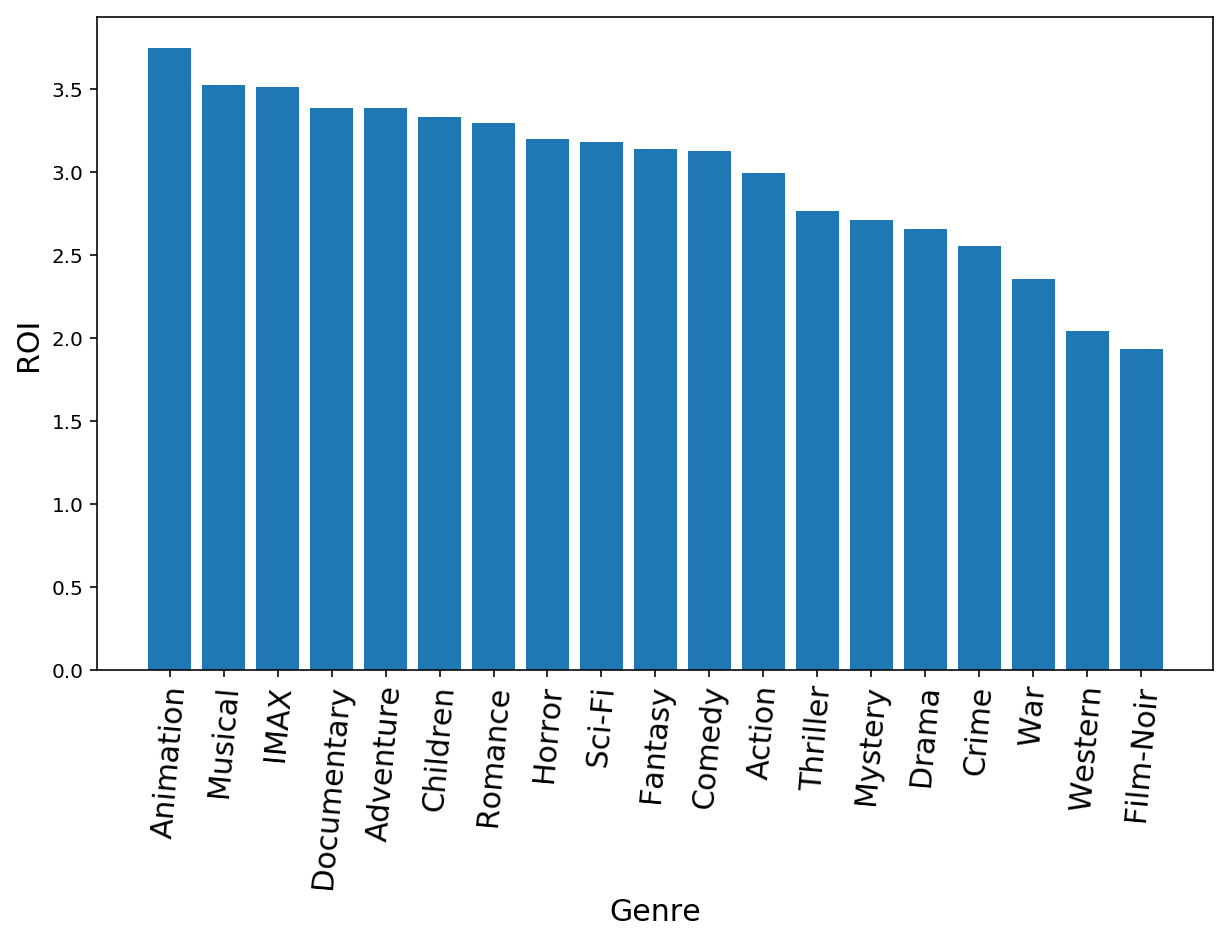

In [220]:
keys, values = zip(*genre_roi[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.xlabel("Genre", fontsize=15)
plt.ylabel("ROI", fontsize=15)
plt.show()